In [1]:
import MY_utils
import opt
from synth_data.utils import results_to_csv
import time

from scipy.sparse import kron, kronsum, eye

import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from os import cpu_count
# %matplotlib qt

SEED = 10
N_CPUS =  cpu_count()

np.random.seed(SEED)
RESULTS_PATH = 'results/efficient_alg/' 

## Filter ID step

### GF ID step

The efficient filter ID step performs N^3 operations at each iteration (no indexing is involved).

In [2]:
NN = [10, 25, 50, 100]
list_iters = [25, 50, 100]
M = 500
p_er = 0.15
noise = 0.01
eps = 0
K = 4
gamma = .1  # .5
mu = .01

times = np.zeros((len(list_iters)+1, len(NN)))
err = np.zeros((len(list_iters)+1, len(NN)))
for i, N in enumerate(NN):
    print('N:', N)
    X, Y, _, _, H, S, _, _ = MY_utils.gen_data(N, M, p_er, noise, eps, K)
    norm_H = np.linalg.norm(H,'fro')
    h = H.flatten('F')

    # Efficient grad
    for j, iters in enumerate(list_iters):
        t = time.time()
        XX = X@X.T
        y_kron = kron(X, eye(N))@Y.flatten(order='F')

        h_init = np.zeros(N**2)

        H_hat, h_iters = opt.efficient_filter_id(XX, S, y_kron, gamma, mu, h_init, eps=1e-3, max_iters=iters, verbose=False)
        times[j,i] = time.time() - t

        err[j,i] = np.linalg.norm(H_hat - H, 'fro')**2/norm_H**2
        print(f'\t- Efficient (iters={iters}): time: {times[j, i]:.3f}s  - err: {err[j,i]:.3f}')

    # Inverse step
    t = time.time()
    X_kron = np.kron(XX, np.eye(N))
    y_kron = np.kron(X, np.eye(N))@Y.flatten(order='F')
    Z = np.kron(S@S, np.eye(N)) + np.kron(np.eye(N), S@S) - 2*np.kron(S, S)
    H_inv = (np.linalg.inv(X_kron + gamma*Z)@y_kron).reshape((N,N), order='F')
    times[-1, i] = time.time() - t

    err[-1,i] = np.linalg.norm(H_inv - H, 'fro')/norm_H
    print(f'\t- Inverse: time: {times[-1, i]:.3f}s  - err: {err[-1,i]:.3f}')


N: 10
	- Efficient (iters=25): time: 0.006s  - err: 0.000
	- Efficient (iters=50): time: 0.006s  - err: 0.000
	- Efficient (iters=100): time: 0.007s  - err: 0.000
	- Inverse: time: 0.007s  - err: 0.011
N: 25
	- Efficient (iters=25): time: 0.036s  - err: 0.001
	- Efficient (iters=50): time: 0.042s  - err: 0.001
	- Efficient (iters=100): time: 0.049s  - err: 0.001
	- Inverse: time: 0.142s  - err: 0.022
N: 50
	- Efficient (iters=25): time: 0.146s  - err: 0.013
	- Efficient (iters=50): time: 0.250s  - err: 0.001
	- Efficient (iters=100): time: 0.243s  - err: 0.001
	- Inverse: time: 1.578s  - err: 0.029
N: 100
	- Efficient (iters=25): time: 1.141s  - err: 0.074
	- Efficient (iters=50): time: 2.153s  - err: 0.007
	- Efficient (iters=100): time: 3.200s  - err: 0.002
	- Inverse: time: 31.166s  - err: 0.037


Text(0, 0.5, 'norm(h-h_hat)/norm(h)')

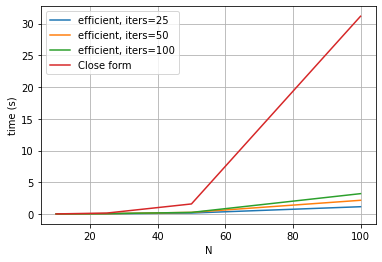

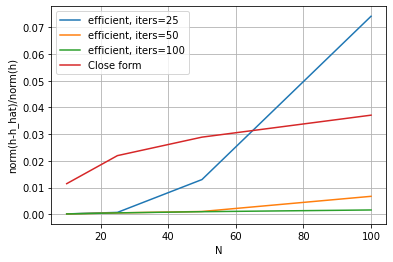

In [3]:
leg = [f'efficient, iters={iters}' for iters in list_iters] + ['Close form']

# Plot time
plt.figure()
plt.plot(NN, times.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')
# plt.savefig(RESULTS_PATH + 'filter_id_time.pdf')

# Plot error
plt.figure()
plt.plot(NN, err.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(h-h_hat)/norm(h)')
# plt.savefig(RESULTS_PATH + 'filter_id_err.pdf')


## Efficiency of the graph denoising step

### Graph denoising step

The graph denoising step updates each of the N^2 enties of S at ever iteration.
Each update of s[i] involves N operations but we need to index a vector of size N^2.

In [7]:
NN = [10, 25, 50, 75, 100] # 50]
list_iters = [50, 150]
M = 500
p_er = 0.15
noise = 0.05
eps = .05
K = 4
lamb = .1  # .1
beta = .01 # .01
gamma = .1

times = np.zeros((len(list_iters)+1, len(NN)))
err = np.zeros((len(list_iters)+1, len(NN)))
Ss = []
Ss_hat = []
for i, N in enumerate(NN):
    print('N:', N)
    _, _, _, _, H, S, Sn, h = MY_utils.gen_data(N, M, p_er, noise, eps, K)
    Ss.append(S)
    norm_S = np.linalg.norm(S, 'fro')

    low_idx = np.concatenate([np.arange(i+1, N)+N*i for i in range(N)])
    s = S.flatten('F')[low_idx]
    sn = Sn.flatten('F')[low_idx]

    Ss_hat.append(np.zeros((len(list_iters), N, N)))

    # Efficient grad
    for j, iters in enumerate(list_iters):
        t = time.time()
        S_hat, s_iters = opt.efficient_graph_id(Sn, H, lamb, beta, gamma, max_iters=iters, verbose=False)
        times[j,i] = time.time() - t
        Ss_hat[i][j,:,:] = S_hat 

        err[j,i] = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2
        err_b = np.linalg.norm(S_hat - S, 'fro')**2/norm_S**2

        print(f'\t- Efficient (iters={iters}): time: {times[j, i]:.3f}s  - err (scale free): {err[j,i]:.3f} - err: {err_b:.3f}')


    # CVX step
    t = time.time()
    S_cvx = opt.graph_id(Sn, H, np.eye(N), lamb, gamma, delta=0)
    times[-1, i] = time.time() - t

    err[-1,i] = np.linalg.norm(S_cvx/np.linalg.norm(S_cvx,'fro') - S/norm_S, 'fro')**2
    err_b = np.linalg.norm(S_cvx - S, 'fro')**2/norm_S**2
    print(f'\t- CVX: time: {times[-1, i]:.3f}s  - err: {err[-1,i]:.3f} - err B: {err_b:.3f}')

N: 10
	- Efficient (iters=50): time: 0.219s  - err (scale free): 0.006 - err: 0.006
	- Efficient (iters=150): time: 0.167s  - err (scale free): 0.006 - err: 0.006
	- CVX: time: 0.019s  - err: 0.003 - err B: 0.003
N: 25
	- Efficient (iters=50): time: 3.195s  - err (scale free): 0.041 - err: 0.857
	- Efficient (iters=150): time: 9.388s  - err (scale free): 0.006 - err: 0.593
	- CVX: time: 0.943s  - err: 0.000 - err B: 0.000
N: 50
	- Efficient (iters=50): time: 12.974s  - err (scale free): 0.119 - err: 0.979
	- Efficient (iters=150): time: 39.542s  - err (scale free): 0.051 - err: 0.929
	- CVX: time: 66.076s  - err: 0.000 - err B: 0.000
N: 75
	- Efficient (iters=50): time: 30.278s  - err (scale free): 0.453 - err: 0.998
	- Efficient (iters=150): time: 87.121s  - err (scale free): 0.253 - err: 0.995
	- CVX: time: 211.692s  - err: 0.000 - err B: 0.000
N: 100
	- Efficient (iters=50): time: 50.814s  - err (scale free): 0.495 - err: 0.994
	- Efficient (iters=150): time: 153.477s  - err (scale 

### Show estimated graphs

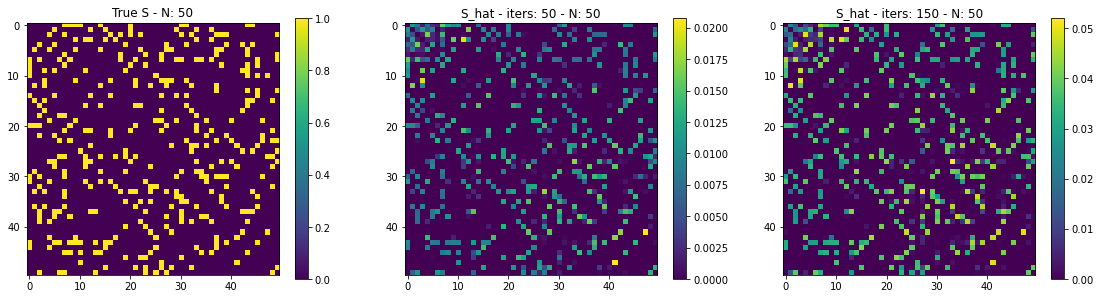

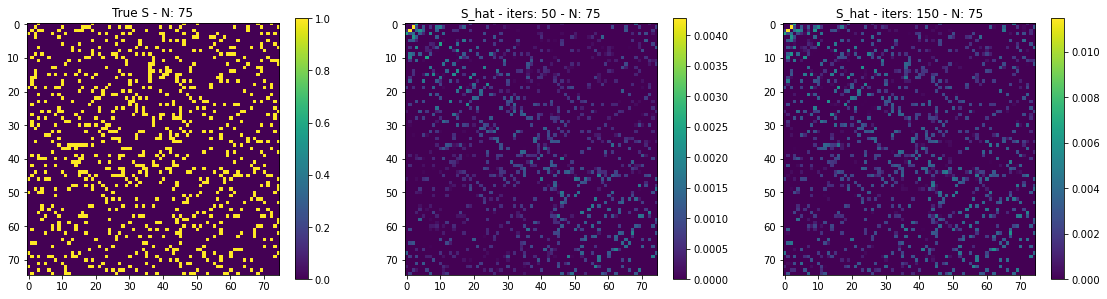

In [8]:
show_sizes = [50, 75]

for i, N in enumerate(NN):
    if N not in show_sizes:
        continue

    plt.figure(figsize=(19.2, 4.8))
    plt.subplot(1, len(list_iters)+1, 1)
    plt.imshow(Ss[i])
    plt.colorbar()
    plt.title(f'True S - N: {N}')

    for j in range(len(list_iters)):
        plt.subplot(1, len(list_iters)+1, j+2)
        plt.imshow(Ss_hat[i][j,:,:])
        plt.colorbar()
        plt.title(f'S_hat - iters: {list_iters[j]} - N: {N}')


Text(0, 0.5, 'norm(s-s_hat)')

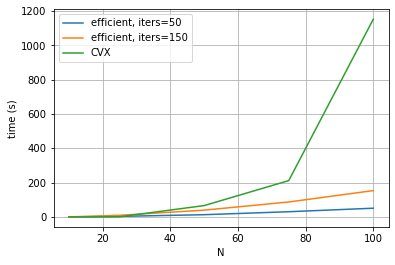

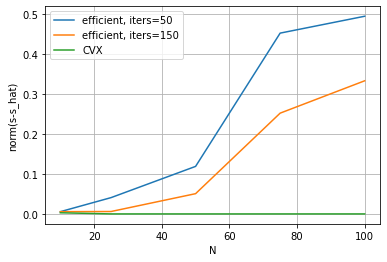

In [9]:
leg = [f'efficient, iters={iters}' for iters in list_iters] + ['CVX']

# Plot time
plt.figure()
plt.plot(NN, times.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error
plt.figure()
plt.plot(NN, err.T)
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(s-s_hat)')

## Check efficient algorithm

In [2]:
NN = [50]  #[10, 20, 30, 40, 50]  #[10, 25, 50, 75, 100]
M = 500
p_er = 0.15
noise = 0.01
eps = .1
K = 4
mu = .01
lamb = .1
gamma = .1
beta = 0
inc_gamma = 1
delta = 0

regs = (lamb, gamma, beta, inc_gamma, mu)
params = (lamb, gamma, delta, inc_gamma)

iters_out = 10
iters_filters = 100
iters_graph = 100

times = np.zeros((2, len(NN)))
err_H = np.zeros((2, len(NN)))
err_S = np.zeros((2, len(NN)))
for i, N in enumerate(NN):
    print('N:', N)
    X, Y, _, _, H, S, Sn, _ = MY_utils.gen_data(N, M, p_er, noise, eps, K)
    norm_H = np.linalg.norm(H, 'fro')
    norm_S = np.linalg.norm(S, 'fro')

    # Efficient algorithms
    t = time.time()
    H_hat, S_hat, Hs_hat, Ss_hat = opt.efficient_rfi(X, Y, Sn, regs, iters_out, iters_filters, iters_graph, eps=1e-6)
    times[0,i] = time.time() - t

    err_H[0,i] = np.linalg.norm(H_hat - H, 'fro')**2/norm_H**2
    err_Hb = np.linalg.norm(H_hat/np.linalg.norm(H_hat, 'fro') - H/norm_H, 'fro')**2
    err_S[0,i] = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2
    err_Sb = np.linalg.norm(S_hat - S, 'fro')**2/norm_S**2

    print(f'\t- Efficient: time: {times[0,i]:.3f}s  - Err H: {err_H[0,i]:.3f} ({err_Hb:.3f})', end='')
    print(f' - Err S: {err_S[0,i]:.3f} ({err_Sb:.3f})')

    # CVX algorithm
    t = time.time()
    H_cvx, S_cvx, diff_H, diff_S = opt.rfi(X, Y, Sn, np.eye(N), params, max_iters=iters_out)
    times[-1, i] = time.time() - t
    
    err_H[-1,i] = np.linalg.norm(H_cvx - H, 'fro')/norm_H
    err_Hb = np.linalg.norm(H_cvx/np.linalg.norm(H_cvx, 'fro') - H/norm_H, 'fro')**2
    err_S[-1,i] = np.linalg.norm(S_cvx/np.linalg.norm(S_cvx, 'fro') - S/norm_S, 'fro')**2
    err_Sb = np.linalg.norm(S_cvx - S, 'fro')/norm_S
    
    print(f'\t- CVX: time: {times[-1,i]:.3f}s  - Err H: {err_H[-1,i]:.3f} ({err_Hb:.3f})', end='')
    print(f' - Err S: {err_S[-1,i]:.3f} ({err_Sb:.3f})')

N: 50
Convergence reached at iteration 2
	- Efficient: time: 55.215s  - Err H: 0.001 (0.001) - Err S: 0.227 (0.972)
Convergence reached at iteration 2
	- CVX: time: 83.998s  - Err H: 0.035 (0.001) - Err S: 0.010 (0.818)


Text(0, 0.5, 'norm(s-s_hat)')

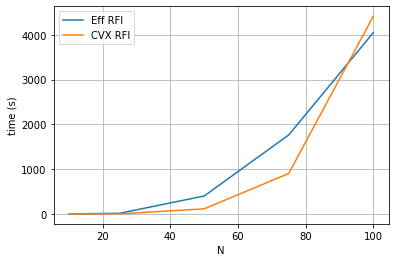

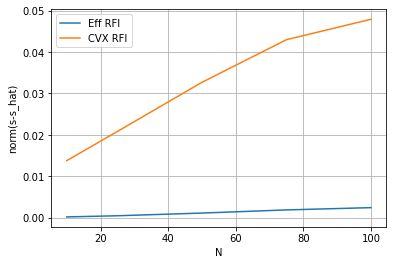

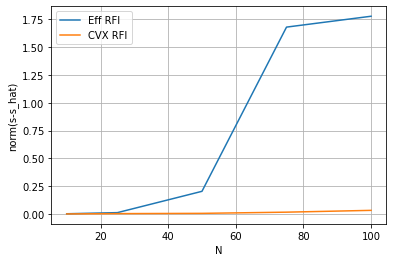

In [ ]:
# Plot time
plt.figure()
plt.plot(NN, times.T)
plt.legend(['Eff RFI', 'CVX RFI'])
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error
plt.figure()
plt.plot(NN, err_H.T)
plt.legend(['Eff RFI', 'CVX RFI'])
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(s-s_hat)')

plt.figure()
plt.plot(NN, err_S.T)
plt.legend(['Eff RFI', 'CVX RFI'])
plt.grid()
plt.xlabel('N')
plt.ylabel('norm(s-s_hat)')

## Experiment 1 - Test efficient algorithm and individual steps

In [2]:
# Experiment parameters
n_graphs = 10
models = ['H-cf', 'H-eff', 'S-CVX', 'S-eff', 'RFI-stand', 'RFI-eff']
fmts = ['--v', '-v', '--+', '-+', '--o', '-o']
n_models = len(models)

NN = [20, 40, 60, 80]  #[10, 25, 50, 75, 100]
M = 500
p_er = 0.15
noise = 0.01
eps = .1
K = 4
mu = .01
lamb = .1
gamma = .1
beta = 0
inc_gamma = 1
delta = 0

regs = (lamb, gamma, beta, inc_gamma, mu)
params = (lamb, gamma, delta, inc_gamma)

iters_out = 10
iters_in = 100

In [3]:
# test_eff_steps
def test_steps(id, NN, M, p, noise, eps, K, regs, params, iters_out, iters_in):
    if id % N_CPUS == 0:
            print(f'Graph {id}:')
    lamb, gamma, beta, inc_gamma, mu = regs
    
    times = np.zeros((n_models, len(NN)))
    err = np.zeros((n_models, len(NN)))
    for i, N in enumerate(NN):
        X, Y, _, _, H, S, Sn, _ = MY_utils.gen_data(N, M, p, noise, eps, K)
        XX = X@X.T
        y_kron = kron(X, eye(N))@Y.flatten(order='F')
        norm_H = np.linalg.norm(H, 'fro')
        norm_S = np.linalg.norm(S, 'fro')

        # Filter step: closed form
        t = time.time()
        X_kron = np.kron(XX, np.eye(N))
        Z = np.kron(S@S, np.eye(N)) + np.kron(np.eye(N), S@S) - 2*np.kron(S, S)
        H_cf = (np.linalg.inv(X_kron + gamma*Z)@y_kron).reshape((N,N), order='F')
        times[0,i] = time.time() - t
        err[0,i] = (np.linalg.norm(H_cf - H, 'fro')/norm_H)**2

        # Filter step: efficient
        t = time.time()
        H_filt, _ = opt.efficient_filter_id(XX, S, y_kron, gamma, mu, max_iters=iters_in)
        times[1,i] = time.time() - t
        err[1,i] = (np.linalg.norm(H_filt - H, 'fro')/norm_H)**2

        # Graph step: CVX
        t = time.time()
        S_cvx = opt.graph_id(Sn, H, np.eye(N), lamb, gamma, delta=0)
        times[2, i] = time.time() - t
        err[2,i] = np.linalg.norm(S_cvx/np.linalg.norm(S_cvx,'fro') - S/norm_S, 'fro')**2

        # Graph step: efficient
        t = time.time()
        S_hat, _ = opt.efficient_graph_id(Sn, H, lamb, beta, gamma, max_iters=iters_in)
        times[3,i] = time.time() - t
        err[3,i] = np.linalg.norm(S_hat/np.linalg.norm(S_hat, 'fro') - S/norm_S, 'fro')**2

        # RFI: standard
        t = time.time()
        H_cvx, S_cvx, _, _ = opt.rfi(X, Y, Sn, np.eye(N), params, max_iters=iters_out, th=0)
        times[4,i] = time.time() - t
        err_H = (np.linalg.norm(H_cvx - H, 'fro')/norm_H)**2
        err_S = np.linalg.norm(S_cvx/np.linalg.norm(S_cvx,'fro') - S/norm_S, 'fro')**2
        err[4,i] = (err_H + err_S)/2

        # RFI: efficient
        t = time.time()
        H_rfi, S_rfi, _, _ = opt.efficient_rfi(X, Y, Sn, regs, iters_out, iters_in, iters_in, eps=0)
        times[5,i] = time.time() - t
        err_H = (np.linalg.norm(H_rfi - H, 'fro')/norm_H)**2
        err_S = np.linalg.norm(S_rfi/np.linalg.norm(S_rfi,'fro') - S/norm_S, 'fro')**2
        err[5,i] = (err_H + err_S)/2

        if id % N_CPUS == 0:
            print(f'\tN={N}: err_H_eff: {err[1,i]:.3f} - err_S_eff: {err[3,i]:.3f} - err_RFI_eff: {err[5,i]:.3f}')
    return times, err


In [4]:

print('N_CPUS:', N_CPUS)

times = np.zeros((n_graphs, n_models, len(NN)))
err = np.zeros((n_graphs, n_models, len(NN)))

total_t = time.time()

pool = Parallel(n_jobs=N_CPUS)
resps = pool(delayed(test_steps)(i, NN, M, p_er, noise, eps, K, regs, params, iters_out, iters_in) for i in range(n_graphs))
for i, resp in enumerate(resps):
    times[i,:,:], err[i,:,:] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')



N_CPUS: 12
----- 555.8691963593166  mins -----


Text(0, 0.5, 'error')

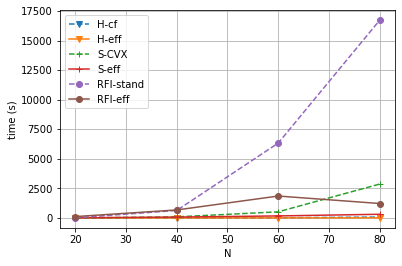

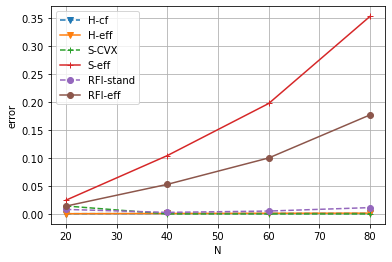

In [5]:
mean_times = times.mean(axis=0)
mean_err = err.mean(axis=0)

# Plot time
plt.figure()
for i, model in enumerate(models):
    plt.plot(NN, mean_times[i,:], fmts[i], label=model)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error
plt.figure()
for i, model in enumerate(models):
    plt.plot(NN, mean_err[i,:], fmts[i], label=model)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('error')

Text(0, 0.5, 'error')

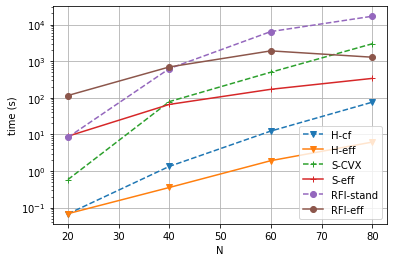

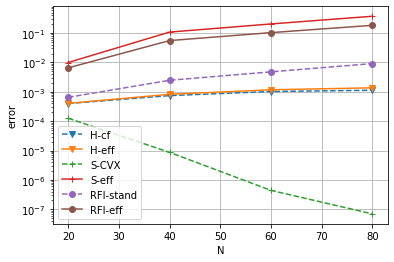

In [6]:
median_times = np.median(times, axis=0)
median_err = np.median(err, axis=0)

# Plot time
plt.figure()
for i, model in enumerate(models):
    plt.semilogy(NN, median_times[i,:], fmts[i], label=model)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error
plt.figure()
for i, model in enumerate(models):
    plt.semilogy(NN, median_err[i,:], fmts[i], label=model)
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('error')

## Experiment 2 - Test number iters

In [5]:
# Experiment parameters
n_graphs = 10
models = [{'name': 'Stand', 'out': 5, 'th': 1e-6, 'fmt': '--'},
          {'name': 'Eff', 'out': 5, 'in': 10, 'th': 1e-6, 'fmt': '-'},
          {'name': 'Eff', 'out': 5, 'in': 50, 'th': 1e-6, 'fmt': '-'},
          {'name': 'Eff', 'out': 5, 'in': 150, 'th': 1e-6, 'fmt': '-'},
          # {'name': 'Eff', 'out': 5, 'in': 200, 'th': 1e-6, 'fmt': '-'},
          # {'name': 'Eff', 'out': 10, 'in': 150, 'th': 0, 'fmt': ':+'},
        ]
n_models = len(models)

NN = [20, 40, 60, 80]  # [20, 30, 40, 50, 60, 70, 80]
M = 500
p_er = 0.15
noise = 0.01
eps = .1
K = 4
mu = .01
lamb = .1
gamma = .1
beta = 0
inc_gamma = 1
delta = 0

regs = (lamb, gamma, beta, inc_gamma, mu)
params = (lamb, gamma, delta, inc_gamma)

In [8]:
# test_eff_iters
def test_iters(id, models, NN, M, p, noise, eps, K, regs, params):
    if id % N_CPUS == 0:
        print(f'Graph {id}')
    
    times = np.zeros((len(models), len(NN)))
    err_H = np.zeros((len(models), len(NN)))
    err_S = np.zeros((len(models), len(NN)))
    for i, N in enumerate(NN):
        X, Y, _, _, H, S, Sn, _ = MY_utils.gen_data(N, M, p, noise, eps, K)
        XX = X@X.T
        y_kron = kron(X, eye(N))@Y.flatten(order='F')
        norm_H = np.linalg.norm(H, 'fro')
        norm_S = np.linalg.norm(S, 'fro')

        for j, model in enumerate(models):
            if model['name'] == 'Eff':
                # RFI: efficient
                t = time.time()
                H_eff, S_eff, _, _ = opt.efficient_rfi(X, Y, Sn, regs, model['out'], model['in'],
                                                       model['in'], eps=model['th'])
                times[j,i] = time.time() - t
                err_H[j,i] = (np.linalg.norm(H_eff - H, 'fro')/norm_H)**2
                err_S[j,i] = np.linalg.norm(S_eff/np.linalg.norm(S_eff,'fro') - S/norm_S, 'fro')**2

            else:
                # RFI: standard
                t = time.time()
                H_st, S_st, _, _ = opt.rfi(X, Y, Sn, np.eye(N), params,
                                           max_iters=model['out'], th=model['th'])
                times[j,i] = time.time() - t
                err_H[j,i] = (np.linalg.norm(H_st - H, 'fro')/norm_H)**2
                err_S[j,i] = np.linalg.norm(S_st/np.linalg.norm(S_st,'fro') - S/norm_S, 'fro')**2
        
        if id % N_CPUS == 0:
            print(f'\t- N = {N} - errs: {np.around(err_H[:,i], 3)}')

    return times, err_H, err_S


In [9]:

print('N_CPUS:', N_CPUS)

times = np.zeros((n_graphs, len(models), len(NN)))
err_H = np.zeros((n_graphs, len(models), len(NN)))
err_S = np.zeros((n_graphs, len(models), len(NN)))

total_t = time.time()

pool = Parallel(n_jobs=N_CPUS)
resps = pool(delayed(test_iters)(i, models, NN, M, p_er, noise, eps, K, regs, params) for i in range(n_graphs))
for i, resp in enumerate(resps):
    times[i,:,:], err_H[i,:,:], err_S[i,:,:] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')



N_CPUS: 12


Text(0, 0.5, 'error S')

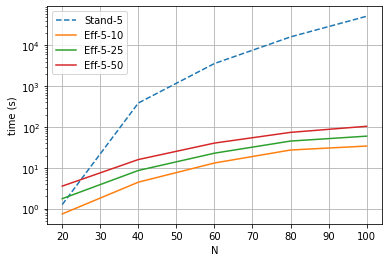

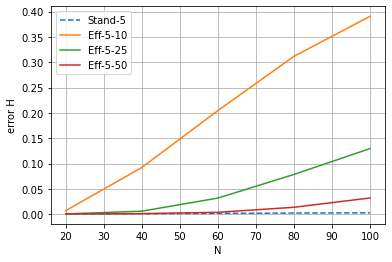

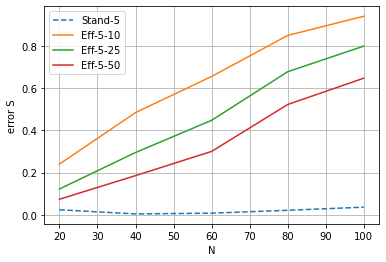

In [4]:
mean_times = times.mean(axis=0)
mean_err_H = err_H.mean(axis=0)
mean_err_S = err_S.mean(axis=0)

# create legend
leg = []
for model in models:
    if model['name'] == 'Eff':
        leg.append(f'{model["name"]}-{model["out"]}-{model["in"]}')
    else:
        leg.append(f'{model["name"]}-{model["out"]}')

# Plot time
plt.figure()
for i, model in enumerate(models):
    plt.semilogy(NN, mean_times[i,:], model['fmt'])
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('time (s)')

# Plot error H
plt.figure()
for i, model in enumerate(models):
    plt.plot(NN, mean_err_H[i,:], model['fmt'])
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('error H')

# Plot error S
plt.figure()
for i, model in enumerate(models):
    plt.plot(NN, mean_err_S[i,:], model['fmt'])
plt.legend(leg)
plt.grid()
plt.xlabel('N')
plt.ylabel('error S')

In [2]:
# Load data
data = np.load('./results/efficient_alg/eff_alg.npy', allow_pickle=True).item()

times = data['times']
err_H = data['err_H']
err_S = data['err_S']
models = data['models']
NN = data['NN']

In [26]:
# To CSV
# def to_csv(fname, result):
#     header = 'x, alg1, alg2, alg3, alg4'
#     NN_np = np.array(NN)
#     data = np.concatenate((NN_np.reshape([NN_np.size, 1]), result.T), axis=1)
#     np.savetxt(fname, data, delimiter=',', header=header, comments='')
#     print('SAVED as:', fname)

# to_csv('results/efficient_alg/mean_times.csv', mean_times)
# to_csv('results/efficient_alg/mean_err_H.csv', mean_err_H)



SAVED as: results/efficient_alg/mean_times.csv
SAVED as: results/efficient_alg/mean_err_H.csv
